# Imports and Setups

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import plotnine as p9
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
import transformer
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from fairnesTester import FairnessTester
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from fairnesTester import FairnessTester

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

#pipelines and transformer

cat_trans = Pipeline(steps=[
    ("selector", transformer.DataSelector("object")),
    ("one_hot", preprocessing.OneHotEncoder())
])
num_trans = Pipeline(steps=[
    ("selector", transformer.DataSelector("number")),
    ("scaler", StandardScaler() )
])

pre_pipe = FeatureUnion(transformer_list=[
    ("cat", cat_trans),
    ("num", num_trans)
])

lb = LabelBinarizer()
del_nan = transformer.DeleteNAN("")

# Importing and preparing the data


## Adult Income Data set

In [ ]:
filename = "Datasets/adult.data"
names = ["age", "workclass", "fnlwgt","education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "class"]
train = pd.read_csv(filename, names=names)
test = test = pd.read_csv("Datasets/adult.test", names=names)

del_nan.set_nan_char(" ?")
train = del_nan.transform(train)
test = del_nan.transform(test)

train["class"] = lb.fit_transform(train["class"])
test["class"] = lb.fit_transform(test["class"])

train_data = pre_pipe.fit_transform(train.drop("class", axis=1))
train_labels = train["class"]

test_data = pre_pipe.transform(test.drop("class", axis=1))
test_labels = test["class"]

#attribute for Fairness tester
dataset_name = "Adult_Income"
priv_val = " Male"
unpriv_val = " Female"
protected_att = "sex"



## German Credit Dataset

In [ ]:
filename = "Datasets/german.data"
names = ["status existing account","duration", "credit history", "purpose", "credit amount", "savings", "employment since", "installment rate", "sex", "other debtors", "residence since", "property", "age", "installment plans", "housing", "num existing credits", "job", "no of pople liable", "telephone", "foreign worker", "class" ]
data = pd.read_csv(filename, sep=" ", names =names)

data["class"] = lb.fit_transform(data["class"])

data, test, train_labels, test_labels = train_test_split(data, data["class"], random_state=42)

train_data = pre_pipe.fit_transform(data.drop("class", axis=1))
test_data = pre_pipe.transform(test.drop("class", axis=1))

#transform for Fairness tester
test["sex"].replace(["A91","A93", "A94"],"m",inplace=True)
test["sex"].replace(["A92","A95"],"f",inplace=True)

#attribute for Fairness tester
dataset_name = "German_Credit"
priv_val = "m"
unpriv_val = "f"
protected_att = "sex"


## Default of Creddit Card Payments

In [ ]:
filename = "Datasets/default of credit.xls"
data_inp = pd.read_excel(filename, dtype={"X1": int,"X2": object,"X3": object,"X4": object,"X5": object,"X6": object,"X7": object,"X8": object,"X9": object,"X10": object,"X11": object,"X12": int,"X13": int,"X14": int,"X15": int,"X16": int,"X17": int,"X23": int,"X18": int,"X19": int,"X20": int,"X21": int,"X22": int})

data_inp = data_inp.rename(columns={"Y": "class"})

data, test, train_labels, test_labels = train_test_split(data_inp, data_inp["class"], random_state=42)

pre_pipe.fit(data_inp.drop("class", axis=1))
train_data = pre_pipe.transform(data.drop("class", axis=1))
test_data = pre_pipe.transform(test.drop("class", axis=1))


#attribute for Fairness tester
dataset_name = "default_of_credit"
priv_val = 1 #male
unpriv_val = 2 #female
protected_att = "X2"



## Rici vs Stefano Dataset

In [ ]:
filename = "Datasets/ricci.csv"
data_inp = pd.read_csv(filename).drop("Unnamed: 0", axis=1)
#applicants with combine >= 70 pass
#read paper Did the Results of Promotion Exams Have a Disparate Impact on Minorities? Using Statistical Evidence in Ricci v. DeStefano
data_inp.rename(columns={"Combine": "class"}, inplace=True)

data_inp.loc[(data_inp["class"]<70), "class"] = 0
data_inp.loc[data_inp["class"]>=70, "class"] = 1


data, test, train_labels, test_labels = train_test_split(data_inp, data_inp["class"], random_state=42)

pre_pipe.fit(data_inp.drop("class", axis=1))
train_data = pre_pipe.transform(data.drop("class", axis=1))
test_data = pre_pipe.transform(test.drop("class", axis=1))

#transform for Fairness tester
test["Race"].replace(["H","B",],"NW",inplace=True)


#attribute for Fairness tester
dataset_name = "ricci_vs_stefano"
priv_val = "W" #white
unpriv_val = "NW" #not white
protected_att = "Race"


## Heart Disease Dataset

In [ ]:
filename = "Datasets/processed.cleveland.data"
names = ["age", "sex", 3,4,5,6,7,8,9,10,11,12,13,"class"]
data_inp = pd.read_csv(filename, names=names)


data_inp.loc[data_inp["class"]>=1, "class"] = 1 #existing heart disase

data, test, train_labels, test_labels = train_test_split(data_inp, data_inp["class"], random_state=42)

pre_pipe.fit(data_inp.drop("class", axis=1))
train_data = pre_pipe.transform(data.drop("class", axis=1))
test_data = pre_pipe.transform(test.drop("class", axis=1))


#attribute for Fairness tester
dataset_name = "heart_diseases_dataset"
priv_val = 1 #male
unpriv_val = 0 #female
protected_att = "sex"

## Heart Failure Dataset

In [ ]:
filename = "Datasets/heart_failure.csv"
data_inp = pd.read_csv(filename)
data_inp.rename(columns={"DEATH_EVENT":"class"}, inplace=True)

data, test, train_labels, test_labels = train_test_split(data_inp, data_inp["class"], random_state=42)


pre_pipe.fit(data_inp.drop("class", axis=1))
train_data = pre_pipe.transform(data.drop("class", axis=1))
test_data = pre_pipe.transform(test.drop("class", axis=1))


#attribute for Fairness tester
dataset_name = "heart_failure_dataset"
priv_val = 1 #male
unpriv_val = 0 #female
protected_att = "sex"

## Student Performance Data Set

In [ ]:
filename = "Datasets/student-por.csv"
data_inp = pd.read_csv(filename, sep=";")

data_inp.drop(["G1","G2"],axis=1,inplace=True)
data_inp.rename(columns={"G3":"class"},inplace=True)

data_inp.loc[(data_inp["class"]<10), "class"] = 0 #failed
data_inp.loc[data_inp["class"]>=10, "class"] = 1 #passed


data, test, train_labels, test_labels = train_test_split(data_inp, data_inp["class"], random_state=42)


pre_pipe.fit(data_inp.drop("class", axis=1))
train_data = pre_pipe.transform(data.drop("class", axis=1))
test_data = pre_pipe.transform(test.drop("class", axis=1))


#attribute for Fairness tester
dataset_name = "student_performance_dataset"
priv_val = "M" #male
unpriv_val = "F" #female
protected_att = "sex"



# Classifiers

## Decision Tree

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(train_data,train_labels)

tree_pred = tree.predict(test_data)
test["prediction"] = tree_pred
dataset_name

## Random Forest

In [ ]:
forest = RandomForestClassifier()
forest.fit(train_data,train_labels)

forest_pred = forest.predict(test_data)
test["prediction"] = forest_pred
dataset_name

## K-Nearest-Neighbour

In [ ]:
knn = KNeighborsClassifier(3)
knn.fit(train_data,train_labels)

knn_pred = knn.predict(test_data)
test["prediction"] = knn_pred
dataset_name 

## Support Vector Machine

In [ ]:
#nochmal dringend anschauen
svc = SVC(kernel="rbf", C=0.025, probability=True) 
svc.fit(train_data,train_labels)

svc_pred = svc.predict(test_data)
test["prediction"] = svc_pred
dataset_name

## Ada Boost 

In [ ]:
ada = AdaBoostClassifier()
svc.fit(train_data,train_labels)

svc_pred = svc.predict(test_data)
test["prediction"] = svc_pred
dataset_name

## Gaussian NB

In [ ]:
gnb = GaussianNB()
gnb.fit(train_data.toarray(),train_labels)

gnb_pred = gnb.predict(test_data.toarray())
test["prediction"] = gnb_pred
dataset_name

## Gaussian Proccess Classifier

In [ ]:
gpc = GaussianProcessClassifier()
gpc.fit(train_data.toarray(),train_labels)

gpc_pred = gpc.predict(test_data.toarray())
test["prediction"] = gpc_pred
gpc.__class__.__name__

# Classifier List


In [ ]:
classifiers = [DecisionTreeClassifier(),RandomForestClassifier(),SVC(),AdaBoostClassifier(),KNeighborsClassifier(5), GaussianNB()]
model_names = []



for model in classifiers:
    
    name = model.__class__.__name__
    print(name)
    model_names.append(name)

    model.fit(train_data.toarray(), train_labels)
    pred = model.predict(test_data.toarray())

    test[name]=pred

# Testing for Fairness


## testing one model

In [ ]:
tester = FairnessTester()
tester.setup(test, protected_att, priv_val, unpriv_val)
print("privileged confusion: \n",tester.priv_confusion_matrix())
print("unprivileged confusion: \n", tester.unpriv_confusion_matrix())
tester.confuison_based_dic()

## testing classifiers list

In [ ]:
tester = FairnessTester()


result_df = pd.DataFrame()

for name in model_names:
    tester.setup(test, protected_att, priv_val, unpriv_val, name)
    result_dic = {"model": name}
    result_dic.update(tester.confusion_based_dic_priv())
    result_df= result_df.append(result_dic, ignore_index=True)
    
    result_dic = {"model": name}
    result_dic.update(tester.confusion_based_dic_unpriv())
    result_df= result_df.append(result_dic, ignore_index=True)
definitions_names = list(tester.confuison_based_dic().keys())
result_df
    

In [ ]:
#fit all data into better selectable format(for complete plot of all definitions)

result_df
full_result_df = pd.DataFrame()
for model in model_names:
    for defi in definitions_names:
        for group in ["priv", "unpriv"]:    
            #if defi == "treatment equality":   #skip treatment equality as it will destroy the scales for full plot
            #    continue          
            dic = {}
            dic["model"] = result_df.loc[(result_df["model"]==model)&(result_df["group"]==group)]["model"].item()
            dic["group"] = result_df.loc[(result_df["model"]==model)&(result_df["group"]==group)]["group"].item()
            dic["definition"] = defi
            dic["result"]= result_df.loc[(result_df["model"]==model)&(result_df["group"]==group)][defi].item()
            full_result_df = full_result_df.append(dic, ignore_index=True)

full_result_df
        

In [ ]:
# get differences from data

differences = pd.DataFrame()

for model in model_names:
    for defi in definitions_names:   
        #if defi == "treatment equality":   #skip treatment equality as it will destroy the scales for full plot
        #    continue          
        dic = {}
        dic["model"] = result_df.loc[(result_df["model"]==model)&(result_df["group"]==group)]["model"].item()
        x = result_df.loc[(result_df["model"]==model)&(result_df["group"]=="priv")][defi].item()
        y = result_df.loc[(result_df["model"]==model)&(result_df["group"]=="unpriv")][defi].item()
        dic["definition"] = defi
        dic["difference"]= abs(x-y)
        differences = differences.append(dic, ignore_index=True)

differences

In [15]:
# get ratio from data

ratio = pd.DataFrame()

for model in model_names:
    for defi in definitions_names:   
        #if defi == "treatment equality":   #skip treatment equality as it will destroy the scales for full plot
        #    continue          
        dic = {}
        dic["model"] = result_df.loc[(result_df["model"]==model)&(result_df["group"]==group)]["model"].item()
        x = result_df.loc[(result_df["model"]==model)&(result_df["group"]=="priv")][defi].item()
        y = result_df.loc[(result_df["model"]==model)&(result_df["group"]=="unpriv")][defi].item()
        dic["definition"] = defi
        dic["ratio"]= y/x
        ratio = ratio.append(dic, ignore_index=True)

ratio

,model,definition,ratio
0,DecisionTreeClassifier,statistical parity,1.138105
1,DecisionTreeClassifier,predictive parity,0.681739
2,DecisionTreeClassifier,negative predictive parity,0.894757
3,DecisionTreeClassifier,equal opportunity,0.727273
4,DecisionTreeClassifier,predictive equality,1.556373
5,DecisionTreeClassifier,overall accuracy equality,0.833476
6,DecisionTreeClassifier,treatment equality,1.222864
7,RandomForestClassifier,statistical parity,1.170524
8,RandomForestClassifier,predictive parity,1.150794
9,RandomForestClassifier,negative predictive parity,1.016365


# Plotting

In [ ]:
#one plot for each definition
plots = []
for definition in definitions_names:

    plot = p9.ggplot(data= result_df, mapping = p9.aes(x="model", y=definition)) + p9.geom_col()+p9.facet_grid("group~.") + p9.theme(axis_text_x = p9.element_text(angle=90))
    plots.append(plot) 

i=0
for plot in plots:
    plot.save(filename="plots/"+dataset_name+"_"+definitions_names[i]+".png")
    i+=1

In [ ]:
#overall plot for all definitions
plot = (p9.ggplot(data= full_result_df, mapping = p9.aes(x="model", y="result")) 
    + p9.geom_col()
    + p9.facet_grid("group~definition", space="free_x", scales="free") 
    + p9.theme(axis_text_x = p9.element_text(angle=90))
    + p9.labs(x="ML Models", y= "Results", title=("Results for " + dataset_name))
    )
plot.save(filename="plots/"+dataset_name+"_complete.png", height=4 , width = 17)


In [ ]:
plot = (p9.ggplot(data= full_result_df, mapping = p9.aes(x="model", y="result", fill="group")) 
    + p9.geom_col(position="dodge")
    + p9.facet_grid(".~definition") 
    + p9.theme(axis_text_x = p9.element_text(angle=90))
    + p9.labs(x="ML Models", y= "Results", title=("Results for " + dataset_name))
    )
plot.save(filename="plots/"+dataset_name+"_complete_color.png", height=4 , width = 17)

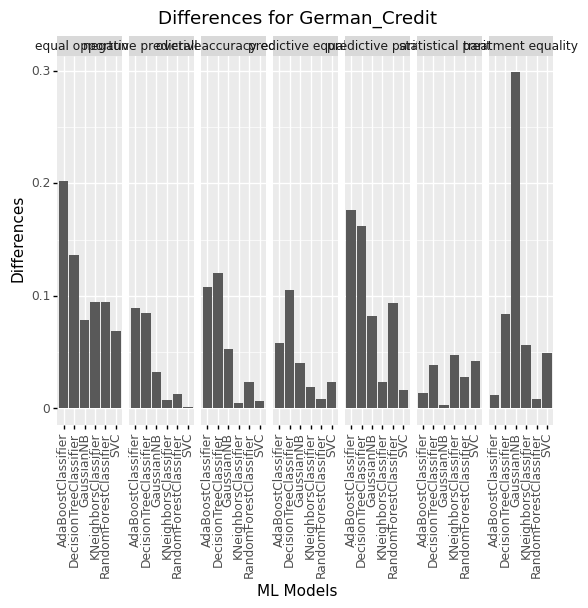

<ggplot: (153394972254)>

In [13]:
# plot differences
plot = (p9.ggplot(data= differences, mapping = p9.aes(x="model", y="difference")) 
    + p9.geom_col()
    + p9.facet_grid(".~definition", space="free_x", scales="free") 
    + p9.theme(axis_text_x = p9.element_text(angle=90))
    + p9.labs(x="ML Models", y= "Differences", title=("Differences for " + dataset_name))
    )
plot


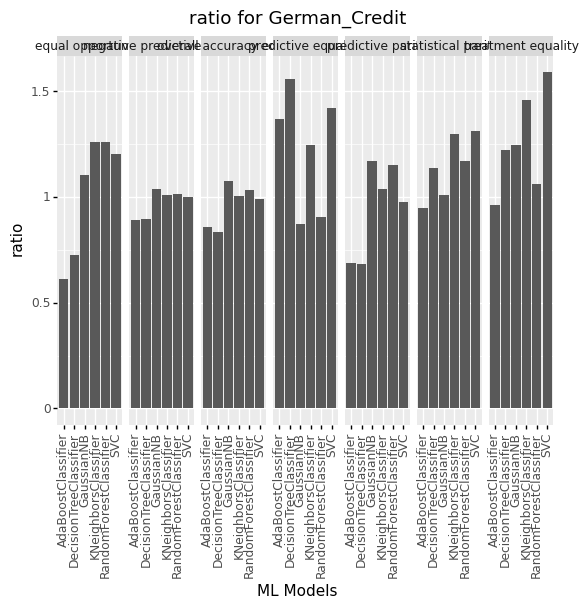

<ggplot: (153396007973)>

In [17]:
plot = (p9.ggplot(data= ratio, mapping = p9.aes(x="model", y="ratio")) 
    + p9.geom_col()
    + p9.facet_grid(".~definition", space="free_x", scales="free") 
    + p9.theme(axis_text_x = p9.element_text(angle=90))
    + p9.labs(x="ML Models", y= "ratio", title=("ratio for " + dataset_name))
    )
plot